<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 23: Keras
### Notebook 11: CNNs

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization

from keras.utils import np_utils
import numpy as np

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
random_seed = 42
np.random.seed(random_seed)

In [5]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['acc']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['acc'], label='train')
    plt.plot(xs, history.history['val_acc'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    file_halper.save_figure(filename)
    plt.show()

In [6]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [-1, 1]
X_train = np.interp(X_train, [0, 255], [-1,1])
X_test = np.interp(X_test, [0, 255], [-1,1])

# save original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape sample data to 4D tensor using channels_last convention 
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

In [7]:
# Make the different CNN models we use in this chapter

def make_simple_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5),
                     activation='relu', padding='same',
                     input_shape=(1, image_height, image_width)))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_bigger_cnn_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3),
                     input_shape=(1, image_height, image_width)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pooling_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3),
                     input_shape=(1, image_height, image_width)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                     kernel_constraint=maxnorm(3))) 
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_striding_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     strides=(2, 2), kernel_constraint=maxnorm(3),
                     input_shape=(1, image_height, image_width)))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                     strides=(2, 2), kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_striding_batchnorm_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation=None, padding='same',
                     strides=(2, 2), 
                     input_shape=(1, image_height, image_width)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pattern_1_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation=None, padding='same',
                     input_shape=(1, image_height, image_width)))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(8, (3, 3), activation=None, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

def make_pattern_2_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation=None, padding='same',
                     input_shape=(1, image_height, image_width)))
    model.add(Conv2D(32, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(16, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
    model.add(Conv2D(8, (3, 3), activation=None, padding='same', 
                     strides=(2, 2))) 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=["accuracy"])
    return model

In [8]:
def run_model(model_maker, plot_title, filename):
    model = model_maker()
    np.random.seed(random_seed)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                     epochs=100, batch_size=256)
    plot_accuracy_and_loss(history, plot_title, filename)
    return history

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 72s - loss: 0.2607 - acc: 0.9254 - val_loss: 0.1005 - val_acc: 0.9710
Epoch 2/100
60000/60000 [==============================] - 69s - loss: 0.0808 - acc: 0.9771 - val_loss: 0.0659 - val_acc: 0.9800
Epoch 3/100
60000/60000 [==============================] - 70s - loss: 0.0589 - acc: 0.9824 - val_loss: 0.0622 - val_acc: 0.9804
Epoch 4/100
60000/60000 [==============================] - 71s - loss: 0.0466 - acc: 0.9859 - val_loss: 0.0538 - val_acc: 0.9831
Epoch 5/100
60000/60000 [==============================] - 75s - loss: 0.0381 - acc: 0.9884 - val_loss: 0.0586 - val_acc: 0.9821
Epoch 6/100
60000/60000 [==============================] - 74s - loss: 0.0324 - acc: 0.9899 - val_loss: 0.0569 - val_acc: 0.9845
Epoch 7/100
60000/60000 [==============================] - 70s - loss: 0.0277 - acc: 0.9911 - val_loss: 0.0543 - val_acc: 0.9839
Epoch 8/100
60000/60000 [======================

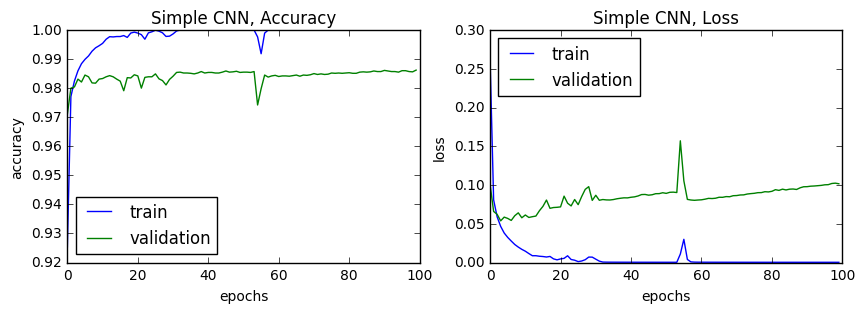

In [9]:
simple_history = run_model(
    make_simple_cnn_model, 'Simple CNN', 'Simple-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 124s - loss: 0.3888 - acc: 0.8844 - val_loss: 0.1024 - val_acc: 0.9692
Epoch 2/100
60000/60000 [==============================] - 124s - loss: 0.1090 - acc: 0.9665 - val_loss: 0.0714 - val_acc: 0.9784
Epoch 3/100
60000/60000 [==============================] - 123s - loss: 0.0835 - acc: 0.9742 - val_loss: 0.0526 - val_acc: 0.9828
Epoch 4/100
60000/60000 [==============================] - 124s - loss: 0.0696 - acc: 0.9789 - val_loss: 0.0547 - val_acc: 0.9821
Epoch 5/100
60000/60000 [==============================] - 126s - loss: 0.0617 - acc: 0.9814 - val_loss: 0.0495 - val_acc: 0.9838
Epoch 6/100
60000/60000 [==============================] - 128s - loss: 0.0566 - acc: 0.9824 - val_loss: 0.0417 - val_acc: 0.9869
Epoch 7/100
60000/60000 [==============================] - 125s - loss: 0.0507 - acc: 0.9840 - val_loss: 0.0397 - val_acc: 0.9877
Epoch 8/100
60000/60000 [===============

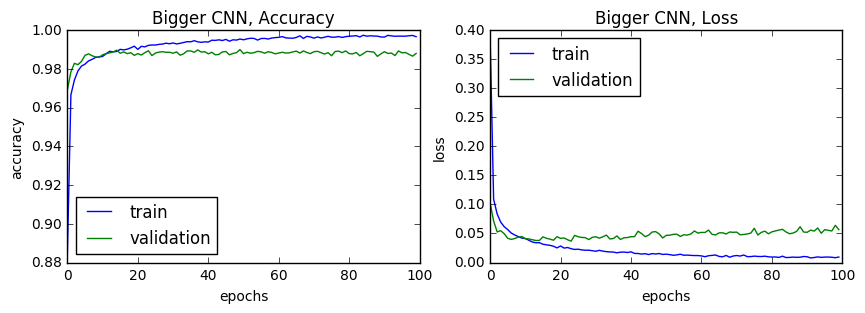

In [10]:
bigger_history = run_model(
    make_bigger_cnn_model, 'Bigger CNN', 'Bigger-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 142s - loss: 0.3157 - acc: 0.9086 - val_loss: 0.1026 - val_acc: 0.9738
Epoch 2/100
60000/60000 [==============================] - 144s - loss: 0.0792 - acc: 0.9755 - val_loss: 0.0595 - val_acc: 0.9841
Epoch 3/100
60000/60000 [==============================] - 144s - loss: 0.0577 - acc: 0.9821 - val_loss: 0.0518 - val_acc: 0.9844
Epoch 4/100
60000/60000 [==============================] - 144s - loss: 0.0447 - acc: 0.9859 - val_loss: 0.0399 - val_acc: 0.9876
Epoch 5/100
60000/60000 [==============================] - 140s - loss: 0.0375 - acc: 0.9879 - val_loss: 0.0417 - val_acc: 0.9873
Epoch 6/100
60000/60000 [==============================] - 138s - loss: 0.0318 - acc: 0.9904 - val_loss: 0.0340 - val_acc: 0.9910
Epoch 7/100
60000/60000 [==============================] - 138s - loss: 0.0279 - acc: 0.9913 - val_loss: 0.0317 - val_acc: 0.9908
Epoch 8/100
60000/60000 [===============

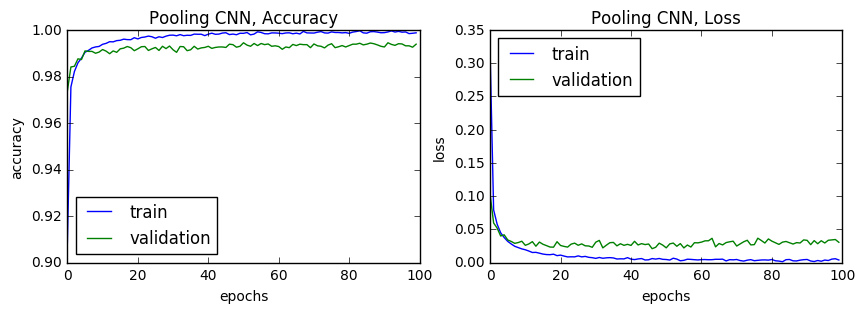

In [11]:
pooling_history = run_model(
    make_pooling_cnn_model, 'Pooling CNN', 'Pooling-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 35s - loss: 0.4440 - acc: 0.8630 - val_loss: 0.1055 - val_acc: 0.9676
Epoch 2/100
60000/60000 [==============================] - 35s - loss: 0.1234 - acc: 0.9626 - val_loss: 0.0639 - val_acc: 0.9792
Epoch 3/100
60000/60000 [==============================] - 32s - loss: 0.0908 - acc: 0.9714 - val_loss: 0.0502 - val_acc: 0.9841
Epoch 4/100
60000/60000 [==============================] - 32s - loss: 0.0750 - acc: 0.9771 - val_loss: 0.0406 - val_acc: 0.9859
Epoch 5/100
60000/60000 [==============================] - 32s - loss: 0.0637 - acc: 0.9802 - val_loss: 0.0435 - val_acc: 0.9845
Epoch 6/100
60000/60000 [==============================] - 32s - loss: 0.0579 - acc: 0.9819 - val_loss: 0.0340 - val_acc: 0.9884
Epoch 7/100
60000/60000 [==============================] - 32s - loss: 0.0497 - acc: 0.9838 - val_loss: 0.0325 - val_acc: 0.9889
Epoch 8/100
60000/60000 [======================

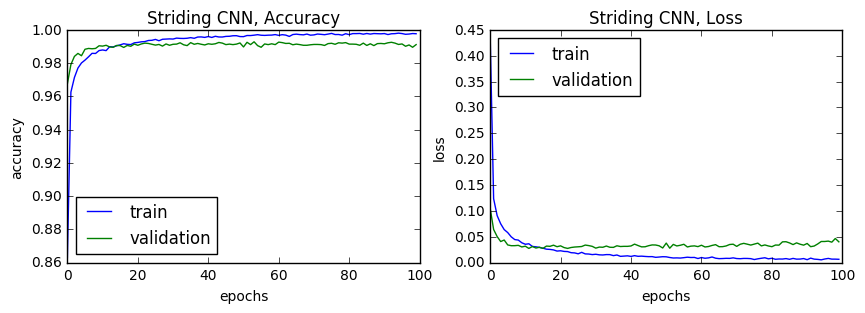

In [12]:
striding_history = run_model(
    make_striding_cnn_model, 'Striding CNN', 'Striding-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 58s - loss: 0.3426 - acc: 0.8984 - val_loss: 0.1307 - val_acc: 0.9722
Epoch 2/100
60000/60000 [==============================] - 54s - loss: 0.0753 - acc: 0.9769 - val_loss: 0.0629 - val_acc: 0.9817
Epoch 3/100
60000/60000 [==============================] - 51s - loss: 0.0541 - acc: 0.9833 - val_loss: 0.0594 - val_acc: 0.9813
Epoch 4/100
60000/60000 [==============================] - 50s - loss: 0.0406 - acc: 0.9878 - val_loss: 0.0434 - val_acc: 0.9858
Epoch 5/100
60000/60000 [==============================] - 47s - loss: 0.0321 - acc: 0.9902 - val_loss: 0.0481 - val_acc: 0.9843
Epoch 6/100
60000/60000 [==============================] - 48s - loss: 0.0251 - acc: 0.9920 - val_loss: 0.0424 - val_acc: 0.9865
Epoch 7/100
60000/60000 [==============================] - 47s - loss: 0.0214 - acc: 0.9931 - val_loss: 0.0360 - val_acc: 0.9883
Epoch 8/100
60000/60000 [======================

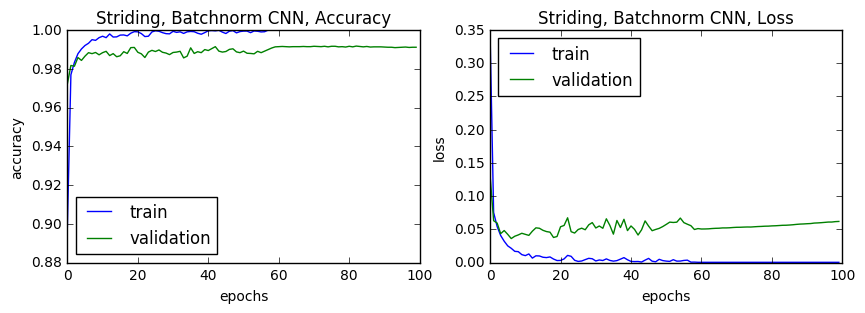

In [13]:
striding_batchnorm_history = run_model(
        make_striding_batchnorm_cnn_model, 
        'Striding, Batchnorm CNN', 'Striding-Batchnorm-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 312s - loss: 0.2551 - acc: 0.9197 - val_loss: 0.0745 - val_acc: 0.9761
Epoch 2/100
60000/60000 [==============================] - 304s - loss: 0.0685 - acc: 0.9781 - val_loss: 0.0826 - val_acc: 0.9725
Epoch 3/100
60000/60000 [==============================] - 303s - loss: 0.0485 - acc: 0.9843 - val_loss: 0.0474 - val_acc: 0.9857
Epoch 4/100
60000/60000 [==============================] - 302s - loss: 0.0396 - acc: 0.9873 - val_loss: 0.0442 - val_acc: 0.9855
Epoch 5/100
60000/60000 [==============================] - 293s - loss: 0.0297 - acc: 0.9903 - val_loss: 0.0398 - val_acc: 0.9875
Epoch 6/100
60000/60000 [==============================] - 293s - loss: 0.0233 - acc: 0.9927 - val_loss: 0.0377 - val_acc: 0.9889
Epoch 7/100
60000/60000 [==============================] - 304s - loss: 0.0235 - acc: 0.9924 - val_loss: 0.0403 - val_acc: 0.9884
Epoch 8/100
60000/60000 [===============

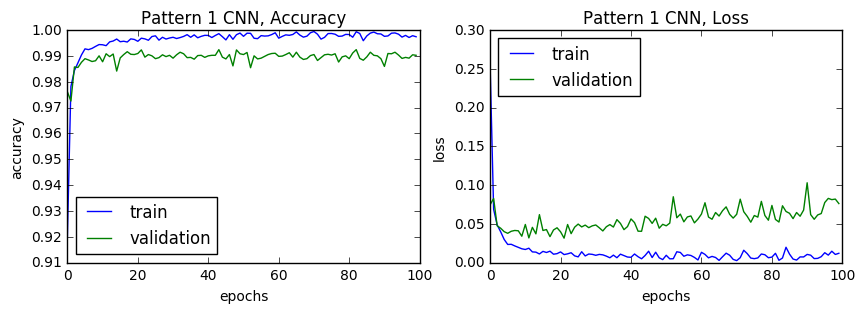

In [14]:
pattern_1_history = run_model(
        make_pattern_1_cnn_model, 'Pattern 1 CNN', 'Pattern-1-CNN-graphs')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 205s - loss: 0.2601 - acc: 0.9218 - val_loss: 0.1223 - val_acc: 0.9615
Epoch 2/100
60000/60000 [==============================] - 188s - loss: 0.0979 - acc: 0.9700 - val_loss: 0.0860 - val_acc: 0.9741
Epoch 3/100
60000/60000 [==============================] - 191s - loss: 0.0740 - acc: 0.9768 - val_loss: 0.0749 - val_acc: 0.9771
Epoch 4/100
60000/60000 [==============================] - 181s - loss: 0.0579 - acc: 0.9818 - val_loss: 0.0748 - val_acc: 0.9765
Epoch 5/100
60000/60000 [==============================] - 180s - loss: 0.0497 - acc: 0.9836 - val_loss: 0.0750 - val_acc: 0.9751
Epoch 6/100
60000/60000 [==============================] - 181s - loss: 0.0414 - acc: 0.9864 - val_loss: 0.0685 - val_acc: 0.9775
Epoch 7/100
60000/60000 [==============================] - 187s - loss: 0.0361 - acc: 0.9885 - val_loss: 0.0757 - val_acc: 0.9802
Epoch 8/100
60000/60000 [===============

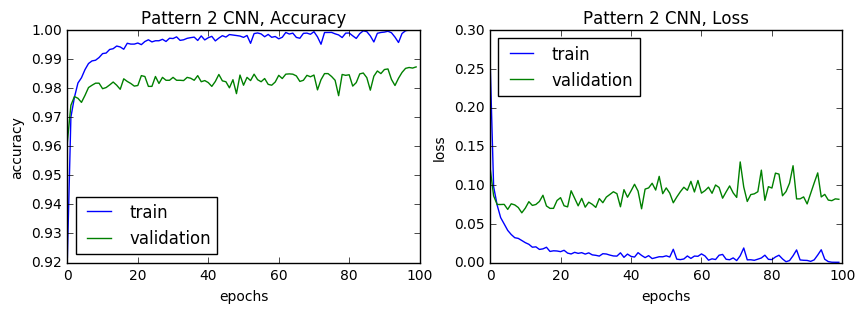

In [15]:
pattern_2_history = run_model(
        make_pattern_2_cnn_model, 'Pattern 2 CNN', 'Pattern-2-CNN-graphs')

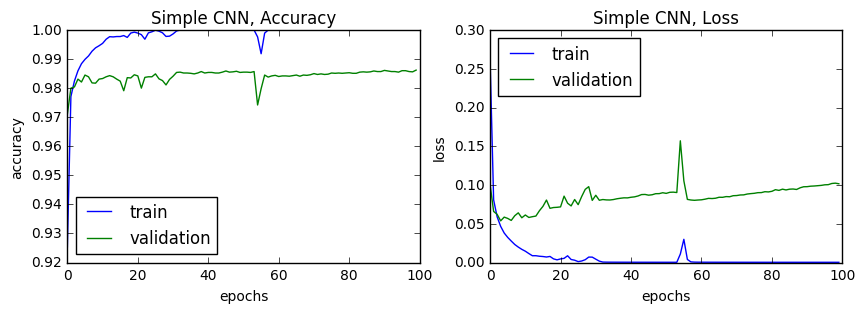

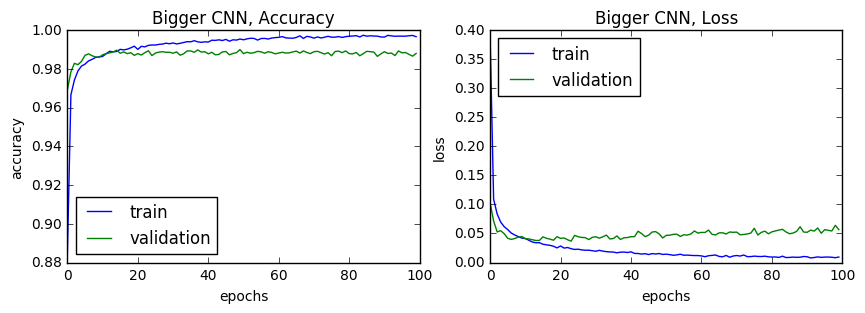

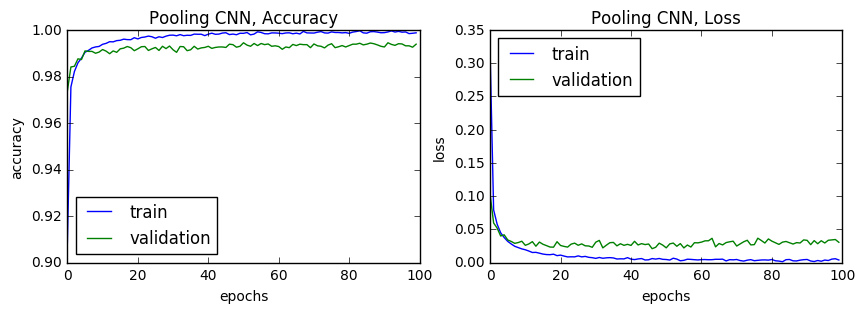

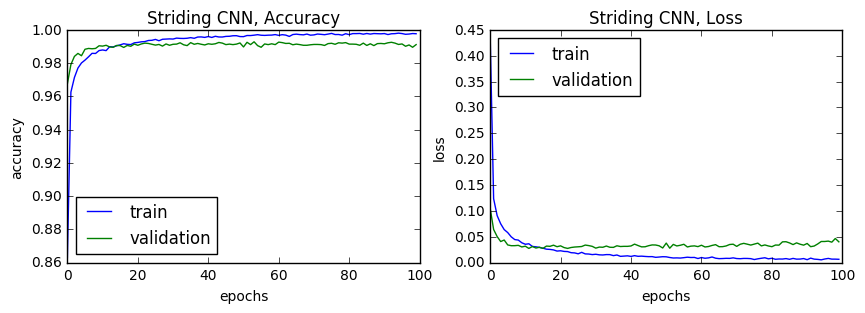

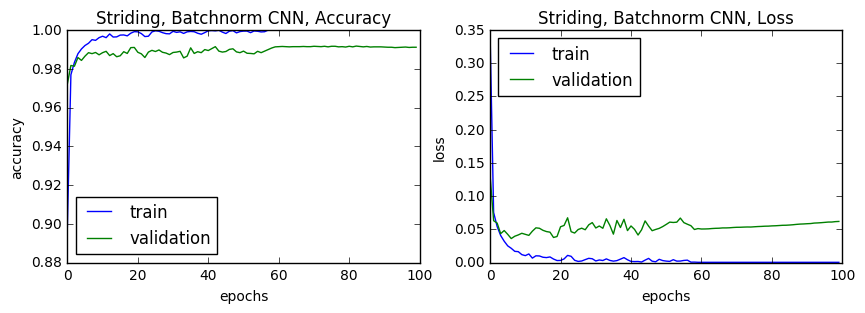

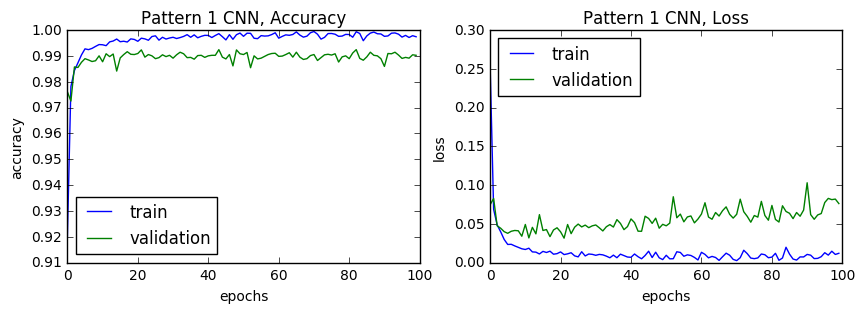

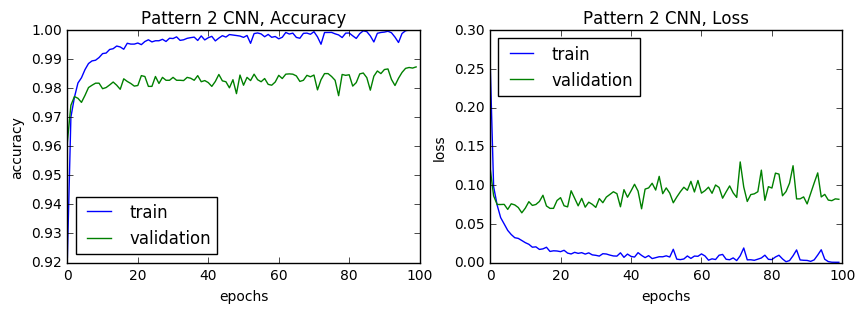

In [16]:
# get the plots by themselves
plot_accuracy_and_loss(simple_history, 'Simple CNN', 'Simple-CNN-graphs')
plot_accuracy_and_loss(bigger_history, 'Bigger CNN', 'Bigger-CNN-graphs')
plot_accuracy_and_loss(pooling_history, 'Pooling CNN', 'Pooling-CNN-graphs')
plot_accuracy_and_loss(striding_history, 'Striding CNN', 'Striding-CNN-graphs')
plot_accuracy_and_loss(striding_batchnorm_history, 'Striding, Batchnorm CNN', 'Striding-Batchnorm-CNN-graphs')
plot_accuracy_and_loss(pattern_1_history, 'Pattern 1 CNN', 'Pattern-1-CNN-graphs')
plot_accuracy_and_loss(pattern_2_history, 'Pattern 2 CNN', 'Pattern-2-CNN-graphs')